In [1]:
import matplotlib.pyplot as plt
import mpl_lego as mplego
import numpy as np
import pandas as pd

from scipy.stats import mannwhitneyu

from hatespeech import utils
from hatespeech.keys import (items,
                             annotator_gender,
                             annotator_gender_col,
                             col_to_gender)
from mpl_lego.colorbar import append_colorbar_to_axis

%matplotlib inline

In [2]:
mplego.style.use_latex_style()

In [3]:
#data_path = '/home/psachdeva/data/scaled-facets-multi-50k-v4.feather'
data_path = '~/data/hatespeech/scaled-facets-multi-50k-v4.feather'

In [4]:
data = pd.read_feather(data_path).rename(columns={'violence_phys': 'violence'})

In [5]:
reference_set = data[data['platform'] == 'reference'].copy()

In [6]:
print(f'Number of unique reference set comments: {reference_set["comment_id"].unique().size}')
print(f'Number of samples in reference set: {reference_set.shape[0]}')

Number of unique reference set comments: 70
Number of samples in reference set: 43227


In [7]:
reference_mw = reference_set[
    (reference_set[annotator_gender_col] == annotator_gender['male']) | 
    (reference_set[annotator_gender_col] == annotator_gender['female'])
]
reference_mw = utils.filter_comments_targeting_mw(reference_mw, threshold=0.5)

In [8]:
reference_mw_targeting_w = reference_mw[reference_mw['target_women']].copy()
reference_mw_targeting_m = reference_mw[~reference_mw['target_women']].copy()

In [9]:
print(f'Number of samples whose annotators are men or women: {reference_mw.shape[0]}')
print(f'Number of samples targeting women whose annotators are men or women: {reference_mw_targeting_w.shape[0]}')
print(f'Number of samples targeting men whose annotators are men or women: {reference_mw_targeting_m.shape[0]}')
print(f'Number of unique comments targeting women: {reference_mw_targeting_w["comment_id"].unique().size}')
print(f'Number of unique comments targeting men: {reference_mw_targeting_m["comment_id"].unique().size}')

Number of samples whose annotators are men or women: 6965
Number of samples targeting women whose annotators are men or women: 6965
Number of samples targeting men whose annotators are men or women: 0
Number of unique comments targeting women: 13
Number of unique comments targeting men: 0


In [10]:
reference_mw_targeting_w['annotator_gender'] = np.where(
    reference_mw_targeting_w[annotator_gender_col] == annotator_gender['male'],
    'male',
    'female')

In [11]:
mw_targeting_w_comments = np.sort(reference_mw_targeting_w['comment_id'].unique())
mw_targeting_w_counts = reference_mw_targeting_w.groupby(['comment_id', 'annotator_gender']).count()
mw_targeting_w_means = reference_mw_targeting_w.groupby(['comment_id', 'annotator_gender']).mean()[items]
mw_targeting_w_diffs = mw_targeting_w_means.diff().query("annotator_gender == 'male'").droplevel('annotator_gender')

In [12]:
p_values = np.zeros((mw_targeting_w_comments.size, len(items)))

for ii, comment_id in enumerate(mw_targeting_w_comments):
    for jj, item in enumerate(items):
        women_scores = reference_mw_targeting_w[
            (reference_mw_targeting_w['comment_id'] == comment_id) &
            (reference_mw_targeting_w['annotator_gender'] == 'male')
        ][item]
        men_scores = reference_mw_targeting_w[
            (reference_mw_targeting_w['comment_id'] == comment_id) &
            (reference_mw_targeting_w['annotator_gender'] == 'female')
        ][item]
        try:
            p_values[ii, jj] = mannwhitneyu(women_scores, men_scores).pvalue
        except:
            p_values[ii, jj] = 1
        
p_values = pd.DataFrame(data=p_values, columns=items, index=mw_targeting_w_comments)

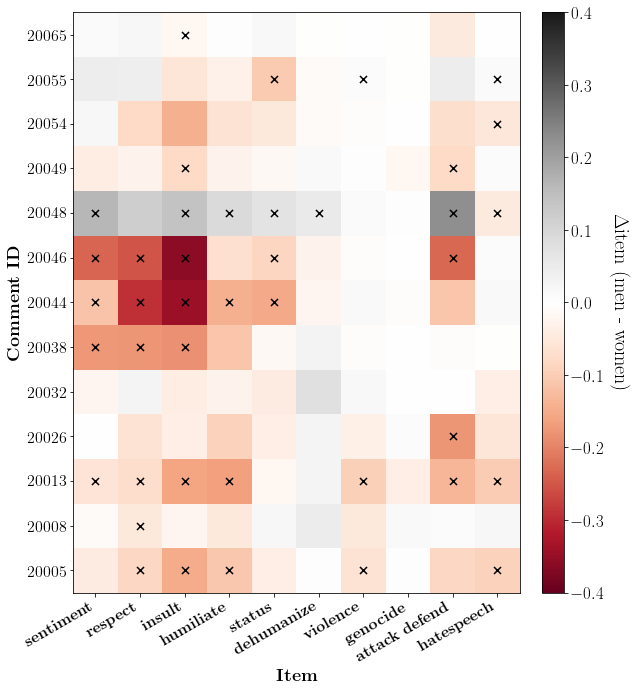

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(8, 12))

img = ax.imshow(mw_targeting_w_diffs, vmin=-0.4, vmax=0.4, cmap='RdGy')
cb, cax = append_colorbar_to_axis(ax, img)
cb.set_label(r'$\Delta$item (men - women)', rotation=270, fontsize=20, labelpad=25)
cb.ax.tick_params(labelsize=17)

for ii in range(p_values.shape[0]):
    for jj in range(p_values.shape[1]):
        if p_values.iloc[ii, jj] < 0.05:
            ax.scatter(jj, ii, marker='x', color='black', s=50)
            
ax.set_xticks(np.arange(len(items)))
ax.set_xticklabels(mplego.labels.bold_text(mplego.labels.fix_labels_for_tex_style(items)), rotation=30, ha='right')
ax.set_yticks(np.arange(len(mw_targeting_w_diffs)))
ax.set_yticklabels(mw_targeting_w_diffs.index)
ax.tick_params(labelsize=16)

ax.set_ylabel(r'\textbf{Comment ID}', fontsize=18)
ax.set_xlabel(r'\textbf{Item}', fontsize=18)
ax.tick_params(labelsize=16)
plt.savefig('men_v_women_comment_comparison.pdf', bbox_inches='tight')
plt.show()

In [17]:
specific_comment = data[data.comment_id == 20046]

In [25]:
annotator_gender

{'female': 1.0,
 'male': 2.0,
 'non-binary': 3.0,
 'self-describe': 4.0,
 'prefer_not_to_say': 5.0}

In [54]:
specific_comment[items].value_counts()

sentiment  respect  insult  humiliate  status  dehumanize  violence  genocide  attack_defend  hatespeech
2.0        2.0      1.0     0.0        0.0     0.0         0.0       0.0       1.0            0.0           28
3.0        3.0      2.0     0.0        1.0     0.0         0.0       0.0       2.0            0.0           24
                                       0.0     0.0         0.0       0.0       2.0            0.0           19
2.0        2.0      0.0     0.0        0.0     0.0         0.0       0.0       1.0            0.0           17
3.0        2.0      1.0     0.0        0.0     0.0         0.0       0.0       1.0            0.0           17
                                                                                                            ..
           3.0      1.0     0.0        1.0     0.0         0.0       0.0       0.0            0.0            1
2.0        1.0      0.0     0.0        1.0     0.0         0.0       0.0       1.0            0.0            1
       

In [30]:
specific_comment[annotator_gender_col].value_counts(dropna=False)

1.0    204
2.0    169
3.0      5
5.0      1
4.0      1
Name: demo_gender, dtype: int64

In [60]:
specific_comment.groupby(annotator_gender_col)[items].quantile(.25).loc[1]

sentiment        3.0
respect          2.0
insult           1.0
humiliate        0.0
status           0.0
dehumanize       0.0
violence         0.0
genocide         0.0
attack_defend    1.0
hatespeech       0.0
Name: 1.0, dtype: float64

In [70]:
specific_comment['predict_text'].iloc[0]

'Men are still ten times more likely to die on the job. As we get more "equality", I don\'t see women taking dangerous jobs from men. Women are taking safe jobs from men so even more men will die on the job. If we were to have a another Vietnam (60,000 killed), 97% will be men. Men die earlier than women, but spending on woman\'s healthcare research (breast, ovarian cancer etc.) is four (4) times greater than the sending on mens healthcare research (prostate, testicular cancer etc.). The list goes on.'

Text(0, 0.5, '\\textbf{Response Rating}')

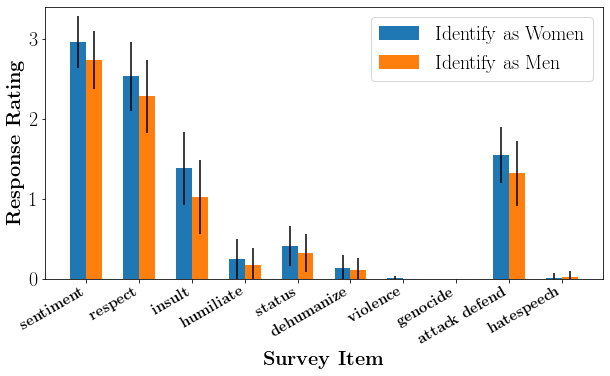

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

width = 0.3

ax.bar(
    x=np.arange(10) - width / 2.,
    height=specific_comment.groupby(annotator_gender_col)[items].mean().loc[1],
    width=width,
    yerr=specific_comment.groupby(annotator_gender_col)[items].std().loc[1] / 2.,
    label='Identify as Women')
ax.bar(
    x=np.arange(10) + width / 2.,
    height=specific_comment.groupby(annotator_gender_col)[items].mean().loc[2],
    width=width,
    yerr=specific_comment.groupby(annotator_gender_col)[items].std().loc[2] / 2.,
    label='Identify as Men')
ax.set_xticks(np.arange(len(items)))
ax.set_xticklabels(mplego.labels.bold_text(mplego.labels.fix_labels_for_tex_style(items)), fontsize=15, rotation=30, ha='right')
ax.set_ylim([0, 3.4])
ax.legend(loc='best', prop={'size': 20})
ax.set_xlabel(r'\textbf{Survey Item}', fontsize=20)
ax.set_ylabel(r'\textbf{Response Rating}', fontsize=20)

In [35]:
specific_comment.groupby(annotator_gender_col)[items].mean()

,sentiment,respect,insult,humiliate,status,dehumanize,violence,genocide,attack_defend,hatespeech
demo_gender,,,,,,,,,,
1.0,2.965686,2.534314,1.382353,0.245098,0.411765,0.132353,0.004902,0.0,1.549020,0.014706
2.0,2.733728,2.284024,1.023669,0.177515,0.325444,0.106509,0.000000,0.0,1.319527,0.023669
3.0,3.200000,2.400000,1.600000,0.400000,0.400000,0.200000,0.000000,0.0,1.800000,0.000000
4.0,4.000000,4.000000,2.000000,2.000000,1.000000,1.000000,0.000000,0.0,3.000000,1.000000
5.0,3.000000,3.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.0,2.000000,0.000000


In [44]:
specific_comment.groupby(annotator_gender_col)[items].std()

,sentiment,respect,insult,humiliate,status,dehumanize,violence,genocide,attack_defend,hatespeech
demo_gender,,,,,,,,,,
1.0,0.653749,0.867474,0.920956,0.504878,0.493364,0.339708,0.070014,0.0,0.710616,0.120669
2.0,0.727920,0.914066,0.931925,0.427302,0.469933,0.309405,0.000000,0.0,0.811911,0.152466
3.0,0.836660,1.516575,1.140175,0.547723,0.547723,0.447214,0.000000,0.0,1.303840,0.000000
4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
comments_w_diffs = pd.concat(
    [reference_mw_targeting_w[reference_mw_targeting_w['comment_id'].isin(mw_targeting_w_comments)][['comment_id', 'predict_text']].sort_values('comment_id').drop_duplicates().reset_index(drop=True),
     (p_values < 0.05).reset_index(drop=True).add_suffix('_sig'),
     mw_targeting_w_diffs.reset_index(drop=True).add_suffix('_diff')],
    axis=1)

In [ ]:
comments_w_diffs.to_csv('men_v_women_comments.csv')